In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, validation_curve
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score,
                             classification_report, roc_curve, auc, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_confusion_matrix, plot_learning_curves


%matplotlib inline

In [2]:
df = pd.read_csv('./credit-g.csv')

df = df.replace({'class': {'good': 1, 'bad': 0}}) # Changing text values to integer values

df = pd.get_dummies(df, columns=['checking_status', 'credit_history', 'purpose', 'savings_status',
                            'employment', 'installment_commitment', 'personal_status',
                            'other_parties', 'residence_since', 'property_magnitude',
                            ' other_payment_plans', 'housing', 'existing_credits', 'job',
                            'num_dependents', 'own_telephone', ' foreign_worker'])

print(df.info())

df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 72 columns):
duration                                         1000 non-null int64
credit_amount                                    1000 non-null int64
age                                              1000 non-null int64
class                                            1000 non-null int64
checking_status_0<=X<200                         1000 non-null uint8
checking_status_<0                               1000 non-null uint8
checking_status_>=200                            1000 non-null uint8
checking_status_no checking                      1000 non-null uint8
credit_history_all paid                          1000 non-null uint8
credit_history_critical/other existing credit    1000 non-null uint8
credit_history_delayed previously                1000 non-null uint8
credit_history_existing paid                     1000 non-null uint8
credit_history_no credits/all paid               1000 non-null uin

,duration,credit_amount,age,class,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,...,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,num_dependents_1,num_dependents_2,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes
224,15,4657,30,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1
49,12,2073,28,1,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,1
477,24,5152,25,1,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,1
884,24,4057,43,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
253,24,4151,35,1,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,1


## Data Processing & Feature Engineering

The dataset we have includes a number of categorical (nominal) features. We need to convert these features into a format usable by the model. We use OneHotEncoding to create a new feature for each value of a category present in the dataset.

For the numerical features in the dataset we scale the values using StandardScaler. 

I have used the Sklearn Pipeline features to improve the reusability of the code.

In [3]:
cleaning_pipeline = ColumnTransformer(transformers=[
    ("numerical_transformer", StandardScaler(), ['duration', 'credit_amount', 'age'])
])

pipe = Pipeline(steps=[
    ('cleaning', cleaning_pipeline),
    
    ('classification', LogisticRegression(solver='lbfgs'))])

## Train Test Split

To train and evaluate the model, I'm splitting the dataset into two different sets; the training set and the test set. The training set will be split multiple times using KFold cross-validation to understand variance within our training process, while the test set will be held out entirely until the model evaluation stage, so we can evaluate our trained model on data the model hasn't been trained on.

In [4]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

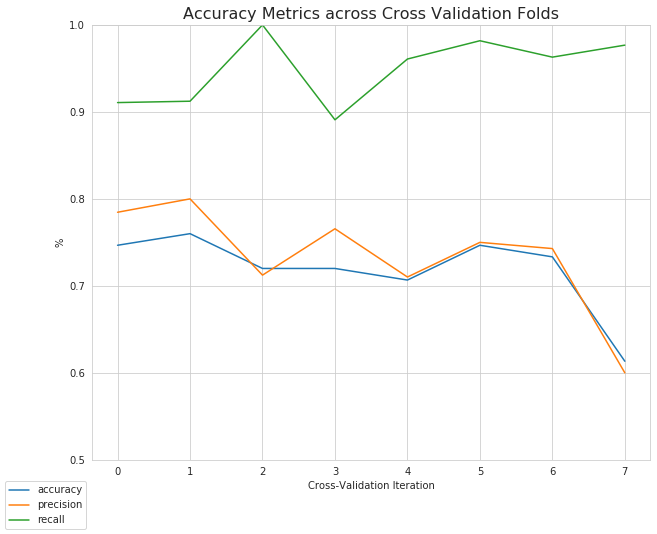

In [5]:
sns.set_style("whitegrid")

performance = []
for train_subset_index, test_index in KFold(n_splits=8).split(X_train):
    X_train_subset, X_test_subset = X.iloc[train_subset_index], X.iloc[test_index]
    y_train_subset, y_test_subset = y.iloc[train_subset_index], y.iloc[test_index]
    pipe.fit(X_train_subset, y_train_subset)
    y_pred = pipe.predict(X_test_subset)
    performance.append({
        'accuracy': accuracy_score(y_test_subset, y_pred),
        'recall': recall_score(y_test_subset, y_pred),
        'precision': precision_score(y_test_subset, y_pred)})

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot([x['accuracy'] for x in performance], label='accuracy')
ax.plot([x['precision'] for x in performance], label='precision')
ax.plot([x['recall'] for x in performance], label='recall')

ax.set_ylim(.5, 1)
ax.set_ylabel('%')
ax.set_xlabel('Cross-Validation Iteration')
ax.set_title('Accuracy Metrics across Cross Validation Folds',
             fontdict={'fontsize': 16});

fig.legend(loc=3);

''

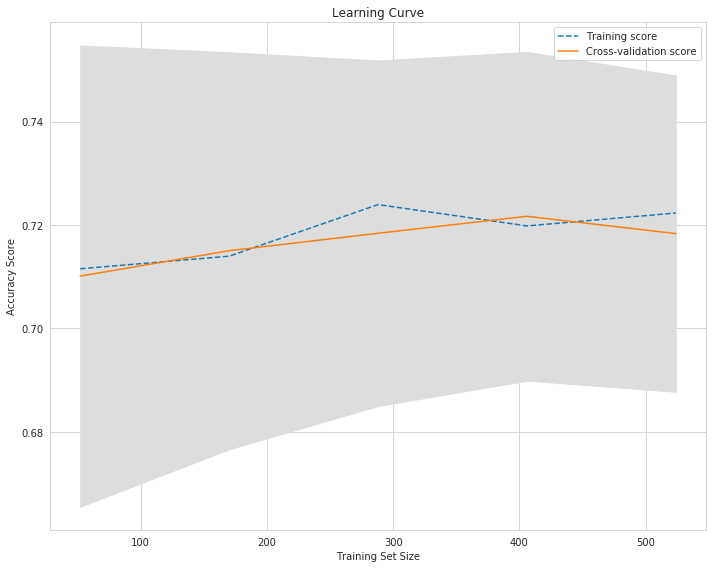

In [6]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 8))

train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train, cv=8)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

ax.plot(train_sizes, train_mean, '--',  label="Training score")
ax.plot(train_sizes, test_mean, label="Cross-validation score")
ax.fill_between(train_sizes, (train_mean - train_std), (train_mean + train_std), color="#DDDDDD")
ax.fill_between(train_sizes, (test_mean - test_std), (test_mean + test_std), color="#DDDDDD")

ax.set_title("Learning Curve")
ax.set_xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
;

## Full Training Set

In [7]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

### Model Evaluation

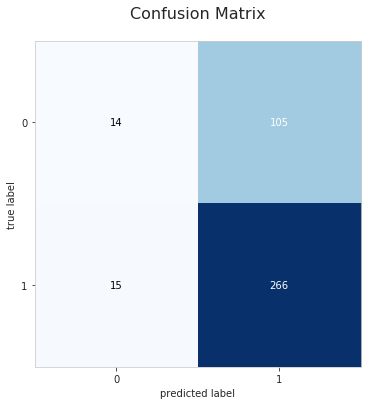

In [8]:
sns.set_style("whitegrid")

fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix(y_test, y_pred, labels=[0, 1]),
    hide_spines=False, hide_ticks=False,
    figsize=(8, 6))

ax.set_title('Confusion Matrix',
             fontdict={'fontsize': 16});

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.12      0.19       119
           1       0.72      0.95      0.82       281

    accuracy                           0.70       400
   macro avg       0.60      0.53      0.50       400
weighted avg       0.65      0.70      0.63       400



Area under the curve score: 0.591


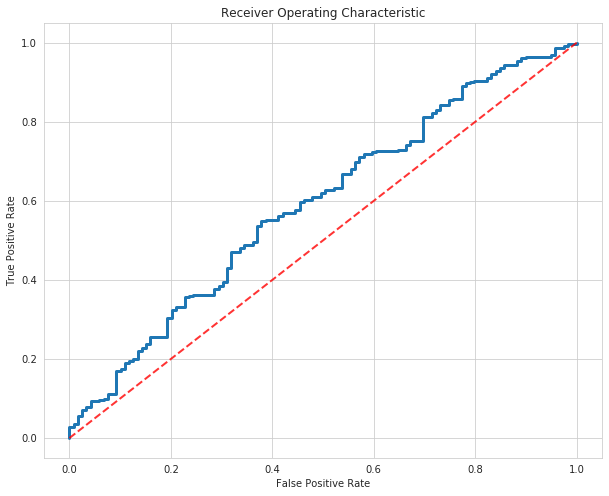

In [10]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 8))
pred_proba = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
auc_score = roc_auc_score(y_test, pred_proba)

ax.plot(fpr, tpr, lw=3)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
ax.set_title('Receiver Operating Characteristic')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')

print('Area under the curve score: {x:0.3}'.format(x=auc_score))

### Performance

The Confusion matrix shows that the performance of our model differs dramatically between the two classes, so while the healine metrics, and the ROC curve are positive, in practice our model has severe limitations.

In [11]:
print('Mean training accuracy score: {x}'.format(x=np.mean([x['accuracy'] for x in performance])))
print('Test set accuracy score: {x}'.format(x=accuracy_score(y_test, y_pred)))


Mean training accuracy score: 0.7183333333333333
Test set accuracy score: 0.7


### Predictions

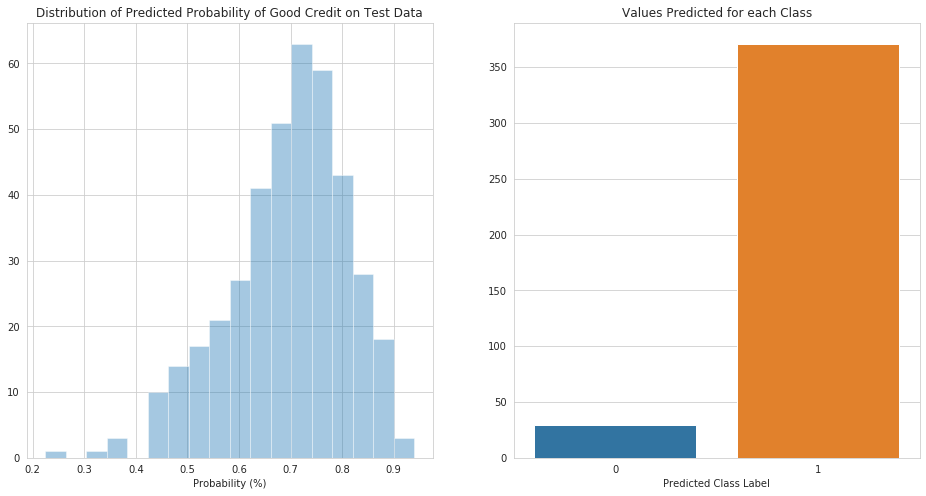

In [12]:
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.distplot(pred_proba, kde=False, ax=ax1)
sns.barplot(x=[0, 1], y=pd.Series(y_pred).value_counts().sort_values(),
            ax=ax2)

ax1.set_title('Distribution of Predicted Probability of Good Credit on Test Data')
ax1.set_xlabel('Probability (%)');

ax2.set_title('Values Predicted for each Class')
ax2.set_xlabel('Predicted Class Label');

# Next steps

### Data Cleaning  
As I don't understand how the data was collected it's hard to understand what non-obvious problems there could be with the data. The data visualisation step didn't highlight any obvious issues with the data, however a less time-limited approach could highlight some issues. One notable issue with the data was the class imbalance on the target variable, as `good` values outweighed `bad` values 700 - 300. This isn't an extreme class imbalance, but it's an opportunity to consider.

### Feature Engineering
While we have used very basic feature engineering in OneHotEncoding and StandardScaling, there is a lot more work we can do in this area. Due to time constraints I didn't perform a more thorough analysis of creating new features and understand what new information they brought to the dataset.

#### Dimensionality Reduction

With the data set transformed using OneHotEncoding we have 72 columns in our dataset, it's very unlikely that they're all informative to a model. There are two broad strategies we could use to help with this, `Feature Selection` and `Feature Extraction`. `Feature Selection` uses a subset of the original features, `Feature Extraction` looks to extract as much information as possible from the existing features, by mapping them into a new feature space (with fewer dimensions to convey the same information.


### Other types of algorithms
I intentionally used `Logistic Regression` for a first pass, as it is a parsimonious model, which is relatively simple to interpret, however there are a lot of other algorithms which may perform better such as RandomForest, Deep Neural Networks or XGBoost.


More work understanding the business problem and what's good enough
---

However the most important next step to take if this was a real situation, is to speak to Stakeholders to better understand the business problem. Understanding how the business process would use the results of the model is always vital, and can help inform technical questions around the important of False Positive and False negative rates, as well broader questions, around how important it is to improve accuracy metrics.

- Identify the three most significant data features which drive the credit risk

I haven't attempted this question, I wasn't sure exactly what was required, and it would have taken a long time. There is a distinction to be made between the features which `cause` credit risk, and features which help the model to `predict` risk. The methodology used in these two cases vary dramatically. The causative factors which underpin and individuals' credit risk would most likely have to be identified by a sociological study. However we can still understand which feautures are most impactful in predicting credit risk, albeit these features are hard to track as we have already used OneHotEncoding which has changed our understanding of features at such an early stage in the modelling process.